<a href="https://colab.research.google.com/github/anobody777/RL/blob/main/%E6%9C%9F%E6%9C%AB%E5%AF%A6%E4%BD%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. 安裝 PettingZoo 和 MPE 環境
!pip install "pettingzoo[mpe]"

# 2. 安裝 Colab 視覺化所需的工具
!pip install pyvirtualdisplay moviepy
!apt-get install -y xvfb python-opengl ffmpeg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 5.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


In [2]:
from google.colab import drive
import os

# 🚨 請注意：這會彈出一個授權窗口，您需要點擊並授權 🚨
drive.mount('/content/gdrive')

# 這就是您的 Drive 路徑，所有文件都會存放在這裡
DRIVE_PATH = '/content/gdrive/MyDrive/MARL_QMIX_Training/'

# 確保路徑存在（如果不存在，就創建它）
os.makedirs(DRIVE_PATH, exist_ok=True)

print(f"Drive mounted. Models will be saved to: {DRIVE_PATH}")

Mounted at /content/gdrive
Drive mounted. Models will be saved to: /content/gdrive/MyDrive/MARL_QMIX_Training/


/usr/local/lib/python3.12/dist-packages/pettingzoo/utils/deprecated_module.py:70: DeprecationWarning: The environment `pettingzoo.mpe.simple_tag_v3` has been moved to `mpe2.simple_tag_v3` and will be removed in a future release. Please update your imports.
  spec.loader.exec_module(module)


Resetting environment with seed=5...
Modifying agent sizes and positions...
Predator 0 set to absolute position: [-0.8 -0.8]
Predator 1 set to absolute position: [-0.4 -0.8]
Predator 2 set to absolute position: [-0.8 -0.4]

Final Predator initial absolute positions: [array([-0.8, -0.8]), array([-0.4, -0.8]), array([-0.8, -0.4])]
Frame captured.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


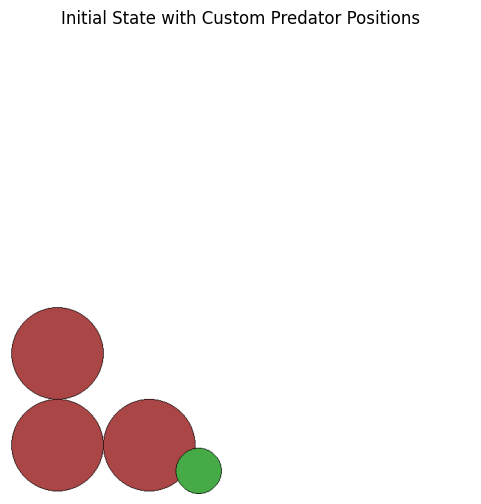

Initial image displayed.


In [ ]:
import pyvirtualdisplay
import gym
import imageio
from pettingzoo.mpe import simple_tag_v3
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np

# --- 1. 啟動虛擬螢幕 ---
try:
    _display.stop()
except:
    pass
_display = pyvirtualdisplay.Display(visible=0, size=(400, 300))
_display.start()

# --- 【!!! 新增設定 !!!】 ---
PREDATOR_NEW_SIZE = 0.2    # 掠食者的新大小
PREY_SIZE = 0.1            # 獵物的大小
SEED_TO_SHOW = 5           # 標準化 SEED
# --------------------------

# 【!!! 關鍵修改：定義新的掠食者初始相對位置 !!!】
predator_rel_positions = [
    [0.1, 0.1],  # 掠食者 0 起始位置
    [0.3, 0.1],  # 掠食者 1 起始位置
    [0.1, 0.3]   # 掠食者 2 起始位置
]

# --- 2. 初始化「簡化後」的環境 ---
env = simple_tag_v3.parallel_env(num_good=1,
                                 num_adversaries=3,
                                 num_obstacles=0,    # 0 個障礙物
                                 max_cycles=75,      # 75 步
                                 continuous_actions=False,
                                 render_mode="rgb_array")

# --- 3. 使用標準 SEED 重置環境 ---
print(f"Resetting environment with seed={SEED_TO_SHOW}...")
# 注意：這裡的 reset 已經設定了大小，但我們稍後會手動覆蓋
observations, infos = env.reset(seed=SEED_TO_SHOW)

# --- 4. 【!!! 關鍵修改 (A) : 手動更改 Agent 大小並設定初始位置 !!!】 ---
print(f"Modifying agent sizes and positions...")
world = env.unwrapped.world

predator_idx = 0
for agent in world.agents:
    if agent.adversary:
        # 這是掠食者
        agent.size = PREDATOR_NEW_SIZE

        # 設定掠食者的新初始位置
        if predator_idx < len(predator_rel_positions):
            # MPE 環境的座標範圍通常是 [-1, 1]，但有些視覺化是 [0, 1]
            # 這裡我們假設您的 [0.5, 0.5] 是指場景的中心點 (即 MPE 坐標系下的 [0, 0])
            # 為了簡單且與您的相對坐標一致，我們直接將其設置為絕對位置
            # MPE 預設坐標系是 [-1, 1] x [-1, 1]，因此 [0.5, 0.5] 是右上角。

            new_pos = np.array(predator_rel_positions[predator_idx]) * 2 - 1.0
            agent.state.p_pos = new_pos
            print(f"Predator {predator_idx} set to absolute position: {agent.state.p_pos}")
            predator_idx += 1

    else:
        # 這是獵物
        agent.size = PREY_SIZE

# --- 5. 獲取最終的掠食者起始位置 ---
predator_positions = []
for agent in world.agents:
    if agent.adversary:
        predator_positions.append(agent.state.p_pos)  # 記錄掠食者的位置

print(f"\nFinal Predator initial absolute positions: {predator_positions}")

# --- 6. 渲染畫面 ---
frame_rgb = env.render()
print("Frame captured.")

# --- 7. 【!!! 關鍵修改 (B) : 顯示初始圖片 !!!】 ---
plt.figure(figsize=(6, 6))
plt.imshow(frame_rgb)
plt.title("Initial State with Custom Predator Positions")
plt.axis('off') # 隱藏軸線
plt.show()
print("Initial image displayed.")
# -----------------------------------------------


# --- 8. 關閉環境 ---
env.close()
_display.stop()

#RL-IQL程式碼

#RL-IQL 視覺化

Visualizing learned IQL policy...
Generating GIF (Max 200 steps, 10 FPS)...
Failure. Time limit 200 reached.


/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


------------------------------
IQL Visualization Saved!
  File: iql_capture_or_timeout.gif
  Result: Failure (Timeout)
  Steps taken: 200
  Video Duration: 20.00 seconds
------------------------------


#MARL-VDN 程式碼

In [3]:
# --- Colab 儲存格 2：完整 MARL (QMIX) 腳本 (已修正) ---

# --- 導入 (Imports) ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque, namedtuple, defaultdict
import time
import math
import pyvirtualdisplay
import gym
import imageio
from pettingzoo.mpe import simple_tag_v3
from IPython.display import Image, display
import os # 確保 os 在此處導入

# --- 1. 啟動虛擬螢幕 ---
try:
    _display.stop()
except:
    pass
_display = pyvirtualdisplay.Display(visible=0, size=(400, 300))
_display.start()
print("Virtual display started.")


# --- 2. 設定超參數 ---
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
LR = 5e-4
TAU = 0.005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 訓練設定
NUM_EPISODES = 2000
MAX_T = 100 # 【!!! 修正 !!!】 MAX_T=1 太短，已改回 100
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995

# QMIX 特有的超參數
MIXER_EMBED_DIM = 32

# 環境修改參數
PREDATOR_NEW_SIZE = 0.15   # 掠食者的新大小
PREY_SIZE = 0.1          # 獵物的大小
NEW_WORLD_RADIUS = 1.0    # 地圖半徑
VISUALIZATION_SEED = 5    # 【!! 標準化 Seed: 5 !!】
MODEL_CHECKPOINT = 100    # 每隔多少回合儲存一次模型
LOAD_EPISODE = 1500          # 設定為 0 則從頭訓練


# --- 3. 共享 Replay Buffer ---
Experience = namedtuple("Experience", field_names=[
    "states", "actions", "reward", "next_states", "done", "global_state", "next_global_state"
])

class SharedReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def push(self, states, actions, reward, next_states, done, global_state, next_global_state):
        e = Experience(states, actions, reward, next_states, done, global_state, next_global_state)
        self.memory.append(e)

    def sample(self, num_agents):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = [torch.from_numpy(np.vstack([e.states[i] for e in experiences if e is not None])).float().to(DEVICE) for i in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.actions[i] for e in experiences if e is not None])).long().to(DEVICE) for i in range(num_agents)]
        next_states = [torch.from_numpy(np.vstack([e.next_states[i] for e in experiences if e is not None])).float().to(DEVICE) for i in range(num_agents)]
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(DEVICE)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(DEVICE)
        global_states = torch.from_numpy(np.vstack([e.global_state for e in experiences if e is not None])).float().to(DEVICE)
        next_global_states = torch.from_numpy(np.vstack([e.next_global_state for e in experiences if e is not None])).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones, global_states, next_global_states)

    def __len__(self):
        return len(self.memory)


# --- 4. Q-Network (Agent 的獨立網路) ---
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# --- 5. QMixer 網路 ---
class QMixer(nn.Module):
    def __init__(self, num_agents, global_state_dim, embed_dim):
        super(QMixer, self).__init__()
        self.num_agents = num_agents
        self.global_state_dim = global_state_dim
        self.embed_dim = embed_dim
        self.hyper_w1 = nn.Linear(global_state_dim, embed_dim * num_agents)
        self.hyper_b1 = nn.Linear(global_state_dim, embed_dim)
        self.hyper_w2 = nn.Linear(global_state_dim, embed_dim)
        self.hyper_b2 = nn.Sequential(nn.Linear(global_state_dim, embed_dim), nn.ReLU(), nn.Linear(embed_dim, 1))

    def forward(self, agent_q_values, global_state):
        batch_size = agent_q_values.size(0)
        w1 = torch.abs(self.hyper_w1(global_state)).view(-1, self.num_agents, self.embed_dim)
        b1 = self.hyper_b1(global_state).view(-1, 1, self.embed_dim)
        w2 = torch.abs(self.hyper_w2(global_state)).view(-1, self.embed_dim, 1)
        b2 = self.hyper_b2(global_state).view(-1, 1, 1)
        agent_q_values = agent_q_values.view(-1, 1, self.num_agents)
        hidden = F.elu(torch.bmm(agent_q_values, w1) + b1)
        q_total = torch.bmm(hidden, w2) + b2
        return q_total.view(-1, 1)


# --- 6. QMIX 管理器 ---
class QMIXManager:
    def __init__(self, state_dims, action_dims, global_state_dim, agent_ids, seed):
        self.agent_ids = agent_ids
        self.num_agents = len(agent_ids)
        self.action_dims_dict = action_dims
        self.global_state_dim = global_state_dim
        self.qnetworks_local = [QNetwork(state_dims[agent_id], action_dims[agent_id], seed + i).to(DEVICE) for i, agent_id in enumerate(agent_ids)]
        self.qnetworks_target = [QNetwork(state_dims[agent_id], action_dims[agent_id], seed + i).to(DEVICE) for i, agent_id in enumerate(agent_ids)]
        self.mixer_local = QMixer(self.num_agents, global_state_dim, MIXER_EMBED_DIM).to(DEVICE)
        self.mixer_target = QMixer(self.num_agents, global_state_dim, MIXER_EMBED_DIM).to(DEVICE)
        all_local_params = []
        for net in self.qnetworks_local: all_local_params.extend(net.parameters())
        all_local_params.extend(self.mixer_local.parameters())
        self.optimizer = optim.Adam(all_local_params, lr=LR)
        self.memory = SharedReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        for local, target in zip(self.qnetworks_local, self.qnetworks_target): target.load_state_dict(local.state_dict())
        self.mixer_target.load_state_dict(self.mixer_local.state_dict())

    def select_actions(self, observations, epsilon=0.):
        actions = {}
        for i, agent_id in enumerate(self.agent_ids):
            obs = observations[agent_id]
            state = torch.from_numpy(obs).float().unsqueeze(0).to(DEVICE)
            self.qnetworks_local[i].eval()
            with torch.no_grad(): action_values = self.qnetworks_local[i](state)
            self.qnetworks_local[i].train()
            if random.random() > epsilon: actions[agent_id] = np.argmax(action_values.cpu().data.numpy())
            else: actions[agent_id] = random.choice(np.arange(self.action_dims_dict[agent_id]))
        return actions

    def push_and_learn(self, states_dict, actions_dict, reward, next_states_dict, done):
        s_tuple = tuple(states_dict[agent_id] for agent_id in self.agent_ids)
        a_tuple = tuple(actions_dict[agent_id] for agent_id in self.agent_ids)
        ns_tuple = tuple(next_states_dict[agent_id] for agent_id in self.agent_ids)
        global_state = np.concatenate(s_tuple)
        next_global_state = np.concatenate(ns_tuple)
        self.memory.push(s_tuple, a_tuple, reward, ns_tuple, done, global_state, next_global_state)
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample(self.num_agents)
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones, global_states, next_global_states = experiences
        Q_targets_next_list = []
        for i in range(self.num_agents):
            Q_targets_next_agent_i = self.qnetworks_target[i](next_states[i]).detach().max(1)[0].unsqueeze(1)
            Q_targets_next_list.append(Q_targets_next_agent_i)
        Q_targets_next_team = torch.cat(Q_targets_next_list, dim=1)
        Q_targets_next_total = self.mixer_target(Q_targets_next_team, next_global_states)
        Q_targets_total = rewards + (gamma * Q_targets_next_total * (1 - dones))
        Q_expected_list = []
        for i in range(self.num_agents):
            Q_expected_agent_i = self.qnetworks_local[i](states[i]).gather(1, actions[i])
            Q_expected_list.append(Q_expected_agent_i)
        Q_expected_team = torch.cat(Q_expected_list, dim=1)
        Q_expected_total = self.mixer_local(Q_expected_team, global_states)
        loss = F.mse_loss(Q_expected_total, Q_targets_total)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update_target_networks(TAU)

    def soft_update_target_networks(self, tau):
        for local, target in zip(self.qnetworks_local, self.qnetworks_target):
            for target_param, local_param in zip(target.parameters(), local.parameters()):
                target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        for target_param, local_param in zip(self.mixer_target.parameters(), self.mixer_local.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# --- 7. 輔助函式 (Load/Save/Prey AI) ---
def save_qmix_model(manager, drive_path, episode_num):
    """將所有 Q-Networks 和 Mixer 的權重儲存到 Google Drive"""
    import torch, os
    model_dir = os.path.join(drive_path, f'episode_{episode_num}')
    os.makedirs(model_dir, exist_ok=True)
    for i, net in enumerate(manager.qnetworks_local):
        path = os.path.join(model_dir, f'qnet_agent_{i}.pth')
        torch.save(net.state_dict(), path)
    path = os.path.join(model_dir, 'mixer.pth')
    torch.save(manager.mixer_local.state_dict(), path)
    print(f"\n--- Model saved to {model_dir} ---")

def load_qmix_model(manager, drive_path, episode_num):
    """從 Google Drive 加載模型權重"""
    import torch, os
    model_dir = os.path.join(drive_path, f'episode_{episode_num}')
    if not os.path.exists(model_dir):
        print(f"--- WARNING: No saved model found at {model_dir}. Starting training from scratch. ---")
        return False
    print(f"--- Loading model from {model_dir} ---")
    for i, net in enumerate(manager.qnetworks_local):
        path = os.path.join(model_dir, f'qnet_agent_{i}.pth')
        net.load_state_dict(torch.load(path, map_location=DEVICE))
    path = os.path.join(model_dir, 'mixer.pth')
    manager.mixer_local.load_state_dict(torch.load(path, map_location=DEVICE))
    manager.soft_update_target_networks(tau=1.0)
    print("--- Model loaded successfully! ---")
    return True

def get_prey_action(prey_observation, predator_observations):
    """獵物的固定策略 (聰明 AI)"""
    # 【!!! 修正 !!!】 使用動態觀測切片，而不是靜態列表
    predator_rel_positions = [
        prey_observation[4:6],  # 掠食者 0
        prey_observation[6:8],  # 掠食者 1
        prey_observation[8:10]  # 掠食者 2
    ]
    distances = [np.linalg.norm(pos) for pos in predator_rel_positions]
    nearest_pred_idx = np.argmin(distances)
    nearest_pred_rel_pos = predator_rel_positions[nearest_pred_idx]
    escape_vector = -np.array(nearest_pred_rel_pos) # 確保是 numpy array
    if np.abs(escape_vector[0]) > np.abs(escape_vector[1]):
        if escape_vector[0] > 0: return 4  # 向右
        else: return 3  # 向左
    else:
        if escape_vector[1] > 0: return 1  # 向上
        else: return 2  # 向下

# --- 8. 初始化「訓練」環境和 QMIX 管理器 ---
print("Initializing TRAINING environment and QMIX Manager...")
env = simple_tag_v3.parallel_env(num_good=1, num_adversaries=3, num_obstacles=0, max_cycles=MAX_T, continuous_actions=False, render_mode="rgb_array")
observations, infos = env.reset(seed=VISUALIZATION_SEED)

print(f"Modifying TRAINING env agent sizes... Predator size: {PREDATOR_NEW_SIZE}")
print(f"Modifying TRAINING env world radius... Radius: {NEW_WORLD_RADIUS}")
world = env.unwrapped
world.world.world_radius = NEW_WORLD_RADIUS
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

predator_ids = [agent for agent in env.agents if 'adversary' in agent]
prey_id = [agent for agent in env.agents if 'agent' in agent][0]
state_dims = {agent_id: env.observation_space(agent_id).shape[0] for agent_id in predator_ids}
action_dims = {agent_id: env.action_space(agent_id).n for agent_id in predator_ids}
global_state_dim = sum(state_dims.values())
print(f"Global State Dimension: {global_state_dim}")

qmix_manager = QMIXManager(state_dims, action_dims, global_state_dim, predator_ids, seed=VISUALIZATION_SEED)

# 【!!! 修正 !!!】 修正了重複加載的邏輯
model_loaded = load_qmix_model(qmix_manager, DRIVE_PATH, LOAD_EPISODE)
if model_loaded:
    epsilon = EPS_END
else:
    epsilon = EPS_START

# --- 9. 【最終版】訓練迴圈 (團隊獎勵 + 隨機獵物 + 捕獲率) ---
print(f"Starting QMIX (MARL) Training from Episode {LOAD_EPISODE + 1}...")
start_time = time.time()
scores = []
scores_window = deque(maxlen=50)
capture_window = deque(maxlen=50)

for i_episode in range(LOAD_EPISODE + 1, NUM_EPISODES + 1):
    observations, infos = env.reset() # (無 seed，隨機開始)
    world = env.unwrapped
    world.world.world_radius = NEW_WORLD_RADIUS
    for agent in world.world.agents:
        if agent.adversary: agent.size = PREDATOR_NEW_SIZE
        else: agent.size = PREY_SIZE

    episode_rewards = {agent_id: 0 for agent_id in predator_ids}
    captured_this_episode = False

    for t in range(MAX_T):
        actions = qmix_manager.select_actions(observations, epsilon)

        # 獵物動作 (低頻率移動)
        if random.random() < 0.1: # 10% 的機率會動
            actions[prey_id] = env.action_space(prey_id).sample()
        else: # 90% 的時間
            actions[prey_id] = 0 # 不動

        next_observations, rewards, terminations, truncations, dones = env.step(actions)

        team_done_by_capture = False
        for agent_id in predator_ids:
            if rewards[agent_id] > 0:
                team_done_by_capture = True
                captured_this_episode = True
                break

        if team_done_by_capture: team_reward = 30.0
        else: team_reward = sum(rewards[agent_id] for agent_id in predator_ids)

        qmix_manager.push_and_learn(observations, actions, team_reward, next_observations, team_done_by_capture)
        observations = next_observations
        for agent_id in predator_ids:
            episode_rewards[agent_id] += rewards[agent_id]

        if team_done_by_capture or all(truncations.values()):
            break

    capture_window.append(1 if captured_this_episode else 0)
    epsilon = max(EPS_END, EPS_DECAY * epsilon)
    team_reward_total = sum(episode_rewards.values())
    scores_window.append(team_reward_total)
    scores.append(team_reward_total)

    if i_episode % MODEL_CHECKPOINT == 0:
        avg_score = np.mean(scores_window)
        capture_rate = np.mean(capture_window) * 100
        print(f'\rEpisode {i_episode}\tAvg Score: {avg_score:.2f}\tCapture Rate: {capture_rate:.1f}%\tEpsilon: {epsilon:.3f}')
        save_qmix_model(qmix_manager, DRIVE_PATH, i_episode)

print(f"\nQMIX Training finished in {(time.time() - start_time) / 60:.2f} minutes.")
env.close() # 關閉訓練環境


# --- 10. 【最終版】視覺化 (輸出兩種測試結果) ---
print("=" * 40)
print(" VISUALIZATION: STARTING ".center(40, "="))
print("=" * 40)

VIS_MAX_STEPS = 100
VIS_FPS = 10
TEST_SEED = VISUALIZATION_SEED # 使用 seed=5

# --- 測試 1：對抗「聰明 AI」 (get_prey_action) ---
print(f"\n[Test 1] Running visualization against SMART prey (seed={TEST_SEED})...")
frames_smart = []
captured_smart = False
capture_step_smart = 0
vis_env_smart = simple_tag_v3.parallel_env(num_good=1, num_adversaries=3, num_obstacles=0, max_cycles=VIS_MAX_STEPS, continuous_actions=False, render_mode="rgb_array")
observations, infos = vis_env_smart.reset(seed=TEST_SEED)
world = vis_env_smart.unwrapped
world.world.world_radius = NEW_WORLD_RADIUS
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

for t in range(VIS_MAX_STEPS):
    frame_rgb = vis_env_smart.render()
    if frame_rgb is None: continue
    frames_smart.append(frame_rgb)
    actions = qmix_manager.select_actions(observations, epsilon=0.0)
    prey_obs = observations[prey_id]
    pred_obs_list = [observations[pid] for pid in predator_ids]
    actions[prey_id] = get_prey_action(prey_obs, pred_obs_list)
    next_observations, rewards, terminations, truncations, infos = vis_env_smart.step(actions)
    observations = next_observations
    for agent_id in predator_ids:
        if rewards[agent_id] > 0:
            print(f"  > Success! SMART Prey captured at step {t+1}.")
            captured_smart = True
            capture_step_smart = t+1
            break
    if captured_smart: break
    if all(truncations.values()):
        print(f"  > Failure. Time limit {VIS_MAX_STEPS} reached.")
        capture_step_smart = t+1
        break
vis_env_smart.close()

# --- 測試 2：對抗「簡單 AI」 (低頻率移動) ---
print(f"\n[Test 2] Running visualization against SIMPLE prey (seed={TEST_SEED})...")
frames_simple = []
captured_simple = False
capture_step_simple = 0
vis_env_simple = simple_tag_v3.parallel_env(num_good=1, num_adversaries=3, num_obstacles=0, max_cycles=VIS_MAX_STEPS, continuous_actions=False, render_mode="rgb_array")
observations, infos = vis_env_simple.reset(seed=TEST_SEED)
world = vis_env_simple.unwrapped
world.world.world_radius = NEW_WORLD_RADIUS
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

for t in range(VIS_MAX_STEPS):
    frame_rgb = vis_env_simple.render()
    if frame_rgb is None: continue
    frames_simple.append(frame_rgb)
    actions = qmix_manager.select_actions(observations, epsilon=0.0)

    # 【關鍵】獵物使用「簡單」AI (低頻率移動)
    if random.random() < 0.1: # 10% 機率隨機
        actions[prey_id] = vis_env_simple.action_space(prey_id).sample()
    else: # 90% 機率不動
        actions[prey_id] = 0

    next_observations, rewards, terminations, truncations, infos = vis_env_simple.step(actions)
    observations = next_observations
    for agent_id in predator_ids:
        if rewards[agent_id] > 0:
            print(f"  > Success! SIMPLE Prey captured at step {t+1}.")
            captured_simple = True
            capture_step_simple = t+1
            break
    if captured_simple: break
    if all(truncations.values()):
        print(f"  > Failure. Time limit {VIS_MAX_STEPS} reached.")
        capture_step_simple = t+1
        break
vis_env_simple.close()

# --- 儲存兩個 GIF 檔 ---
# 儲存 GIF 1
output_gif_path_smart = "qmix_marl_vs_SMART_prey.gif"
imageio.mimsave(output_gif_path_smart, frames_smart, fps=VIS_FPS)
num_frames_smart = len(frames_smart)
duration_sec_smart = num_frames_smart / VIS_FPS
print("-" * 30)
print(f"QMIX (MARL) vs SMART Prey Saved!")
print(f"  File: {output_gif_path_smart}")
if captured_smart: print(f"  Result: Success (Captured)")
else: print(f"  Result: Failure (Timeout)")
print(f"  Steps taken: {num_frames_smart}")
print(f"  Video Duration: {duration_sec_smart:.2f} seconds")
print("-" * 30)

# 儲存 GIF 2
output_gif_path_simple = "qmix_marl_vs_SIMPLE_prey.gif"
imageio.mimsave(output_gif_path_simple, frames_simple, fps=VIS_FPS)
num_frames_simple = len(frames_simple)
duration_sec_simple = num_frames_simple / VIS_FPS
print("-" * 30)
print(f"QMIX (MARL) vs SIMPLE Prey Saved!")
print(f"  File: {output_gif_path_simple}")
if captured_simple: print(f"  Result: Success (Captured)")
else: print(f"  Result: Failure (Timeout)")
print(f"  Steps taken: {num_frames_simple}")
print(f"  Video Duration: {duration_sec_simple:.2f} seconds")
print("-" * 30)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

Virtual display started.
Using device: cpu
Initializing TRAINING environment and QMIX Manager...
Modifying TRAINING env agent sizes... Predator size: 0.15
Modifying TRAINING env world radius... Radius: 1.0
Global State Dimension: 36
--- Loading model from /content/gdrive/MyDrive/MARL_QMIX_Training/episode_900 ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


--- Model loaded successfully! ---
Starting QMIX (MARL) Training from Episode 901...
Episode 1000	Avg Score: 9.00	Capture Rate: 30.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1000 ---
Episode 1100	Avg Score: 10.20	Capture Rate: 34.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1100 ---
Episode 1200	Avg Score: 15.00	Capture Rate: 48.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1200 ---
Episode 1300	Avg Score: 12.60	Capture Rate: 42.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1300 ---
Episode 1400	Avg Score: 10.80	Capture Rate: 36.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1400 ---
Episode 1500	Avg Score: 11.40	Capture Rate: 36.0%	Epsilon: 0.010

--- Model saved to /content/gdrive/MyDrive/MARL_QMIX_Training/episode_1500 ---

QMIX Training finished in 6.60 minutes.
=====

/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


------------------------------
QMIX (MARL) vs SMART Prey Saved!
  File: qmix_marl_vs_SMART_prey.gif
  Result: Failure (Timeout)
  Steps taken: 100
  Video Duration: 10.00 seconds
------------------------------
------------------------------
QMIX (MARL) vs SIMPLE Prey Saved!
  File: qmix_marl_vs_SIMPLE_prey.gif
  Result: Failure (Timeout)
  Steps taken: 100
  Video Duration: 10.00 seconds
------------------------------


In [ ]:
# --- 10. 【最終版】視覺化 (輸出兩種測試結果) ---

print("=" * 40)
print(" VISUALIZATION: STARTING ".center(40, "="))
print("=" * 40)

VIS_MAX_STEPS = 100
VIS_FPS = 10
TEST_SEED = 8 # <--- 使用您選擇的標準化 Seed

# --- 測試 1：對抗「聰明 AI」 (get_prey_action) ---
# ----------------------------------------------------
print(f"\n[Test 1] Running visualization against SMART prey (seed={TEST_SEED})...")

frames_smart = []
captured_smart = False
capture_step_smart = 0

# 建立視覺化環境
vis_env_smart = simple_tag_v3.parallel_env(num_good=1,
                                     num_adversaries=3,
                                     num_obstacles=0,
                                     max_cycles=VIS_MAX_STEPS,
                                     continuous_actions=False,
                                     render_mode="rgb_array")

observations, infos = vis_env_smart.reset(seed=TEST_SEED)

# --- 設定「視覺化」環境的屬性 ---
world = vis_env_smart.unwrapped
world.world.world_radius = NEW_WORLD_RADIUS
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

for t in range(VIS_MAX_STEPS):
    frame_rgb = vis_env_smart.render()
    if frame_rgb is None: continue
    frames_smart.append(frame_rgb)

    # 掠食者使用 QMIX 策略
    actions = qmix_manager.select_actions(observations, epsilon=0.0)

    # 【關鍵】獵物使用「聰明」AI
    prey_obs = observations[prey_id]
    pred_obs_list = [observations[pid] for pid in predator_ids]
    actions[prey_id] = get_prey_action(prey_obs, pred_obs_list)

    next_observations, rewards, terminations, truncations, infos = vis_env_smart.step(actions)
    observations = next_observations

    # 使用「獎勵」來判斷捕捉
    for agent_id in predator_ids:
        if rewards[agent_id] > 0:
            print(f"  > Success! SMART Prey captured at step {t+1}.")
            captured_smart = True
            capture_step_smart = t+1
            break
    if captured_smart: break
    if all(truncations.values()):
        print(f"  > Failure. Time limit {VIS_MAX_STEPS} reached.")
        capture_step_smart = t+1
        break
vis_env_smart.close()


# --- 測試 2：對抗「簡單 AI」 (低頻率移動) ---
# (這能驗證 QMIX 是否至少學會了它在訓練中看到的任務)
# ----------------------------------------------------
print(f"\n[Test 2] Running visualization against SIMPLE prey (seed={TEST_SEED})...")

frames_simple = []
captured_simple = False
capture_step_simple = 0

# 建立視覺化環境
vis_env_simple = simple_tag_v3.parallel_env(num_good=1,
                                     num_adversaries=3,
                                     num_obstacles=0,
                                     max_cycles=VIS_MAX_STEPS,
                                     continuous_actions=False,
                                     render_mode="rgb_array")

observations, infos = vis_env_simple.reset(seed=TEST_SEED) # <--- 同樣使用 seed=5

# --- 設定「視覺化」環境的屬性 ---
world = vis_env_simple.unwrapped
world.world.world_radius = NEW_WORLD_RADIUS
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

for t in range(VIS_MAX_STEPS):
    frame_rgb = vis_env_simple.render()
    if frame_rgb is None: continue
    frames_simple.append(frame_rgb)

    # 掠食者使用 QMIX 策略
    actions = qmix_manager.select_actions(observations, epsilon=0.0)

    # 【關鍵】獵物使用「簡單」AI (低頻率移動)
    if random.random() < 0.1: # 10% 機率隨機
        actions[prey_id] = vis_env_simple.action_space(prey_id).sample()
    else: # 90% 機率不動
        actions[prey_id] = 0

    next_observations, rewards, terminations, truncations, infos = vis_env_simple.step(actions)
    observations = next_observations

    # 使用「獎勵」來判斷捕捉
    for agent_id in predator_ids:
        if rewards[agent_id] > 0:
            print(f"  > Success! SIMPLE Prey captured at step {t+1}.")
            captured_simple = True
            capture_step_simple = t+1
            break
    if captured_simple: break
    if all(truncations.values()):
        print(f"  > Failure. Time limit {VIS_MAX_STEPS} reached.")
        capture_step_simple = t+1
        break
vis_env_simple.close()

# --- 儲存兩個 GIF 檔 ---

# 儲存 GIF 1
output_gif_path_smart = "qmix_marl_vs_SMART_prey.gif"
imageio.mimsave(output_gif_path_smart, frames_smart, fps=VIS_FPS)
num_frames_smart = len(frames_smart)
duration_sec_smart = num_frames_smart / VIS_FPS

print("-" * 30)
print(f"QMIX (MARL) vs SMART Prey Saved!")
print(f"  File: {output_gif_path_smart}")
if captured_smart:
    print(f"  Result: Success (Captured)")
else:
    print(f"  Result: Failure (Timeout)")
print(f"  Steps taken: {num_frames_smart}")
print(f"  Video Duration: {duration_sec_smart:.2f} seconds")
print("-" * 30)

# 儲存 GIF 2
output_gif_path_simple = "qmix_marl_vs_SIMPLE_prey.gif"
imageio.mimsave(output_gif_path_simple, frames_simple, fps=VIS_FPS)
num_frames_simple = len(frames_simple)
duration_sec_simple = num_frames_simple / VIS_FPS

print("-" * 30)
print(f"QMIX (MARL) vs SIMPLE Prey Saved!")
print(f"  File: {output_gif_path_simple}")
if captured_simple:
    print(f"  Result: Success (Captured)")
else:
    print(f"  Result: Failure (Timeout)")
print(f"  Steps taken: {num_frames_simple}")
print(f"  Video Duration: {duration_sec_simple:.2f} seconds")
print("-" * 30)

======= VISUALIZATION: STARTING ========

[Test 1] Running visualization against SMART prey (seed=8)...
  > Failure. Time limit 100 reached.

[Test 2] Running visualization against SIMPLE prey (seed=8)...
  > Success! SIMPLE Prey captured at step 15.
------------------------------
QMIX (MARL) vs SMART Prey Saved!
  File: qmix_marl_vs_SMART_prey.gif
  Result: Failure (Timeout)
  Steps taken: 100
  Video Duration: 10.00 seconds
------------------------------
------------------------------
QMIX (MARL) vs SIMPLE Prey Saved!
  File: qmix_marl_vs_SIMPLE_prey.gif
  Result: Success (Captured)
  Steps taken: 15
  Video Duration: 1.50 seconds
------------------------------


#MARL-VDN 視覺化

In [ ]:
# (這段程式碼在您完成 MARL 之後執行)
import imageio.v3 as iio

# 讀取您生成的兩個 GIF
frames_iql = iio.imread(f"iql_trained_with_trails.gif", index=None)
frames_marl = iio.imread(f"marl_trained_with_trails.gif", index=None)

# 確保兩個 GIF 幀數相同 (如果不同，取較短的)
min_frames = min(len(frames_iql), len(frames_marl))

combined_frames = []
for i in range(min_frames):
    # 水平拼接 (axis=1)
    combined_frame = np.concatenate((frames_iql[i], frames_marl[i]), axis=1)
    combined_frames.append(combined_frame)

# 儲存最終的對比 GIF
iio.mimsave("final_comparison.gif", combined_frames, fps=15)
print("Final comparison GIF saved!")

#TEST

In [ ]:
import pyvirtualdisplay
import gym
import imageio
import numpy as np
import time
from pettingzoo.mpe import simple_tag_v3

print("--- 啟動「最終物理引擎」測試 (Termination Test v3) ---")

# --- 1. 啟動虛擬螢幕 ---
try:
    _display.stop()
except:
    pass
_display = pyvirtualdisplay.Display(visible=0, size=(400, 300))
_display.start()

# --- 2. 定義測試用的「環境參數」 ---
PREDATOR_NEW_SIZE = 0.1
PREY_SIZE = 0.05
SEED_TO_TEST = 42
TEST_MAX_STEPS = 50

# --- 3. 執行測試迴圈 (無 AI，純手動) ---
print(f"載入環境... (Seed={SEED_TO_TEST}, Pred_Size={PREDATOR_NEW_SIZE})")
test_env = simple_tag_v3.parallel_env(num_good=1,
                                     num_adversaries=3,
                                     num_obstacles=0,
                                     max_cycles=TEST_MAX_STEPS,
                                     continuous_actions=False,
                                     render_mode="rgb_array")

observations, infos = test_env.reset(seed=SEED_TO_TEST)

# 【關鍵】設定 Agent 大小
world = test_env.unwrapped
for agent in world.world.agents:
    if agent.adversary: agent.size = PREDATOR_NEW_SIZE
    else: agent.size = PREY_SIZE

# 取得 ID (我們需要它們的字串名稱)
predator_ids = [agent for agent in test_env.agents if 'adversary' in agent]
prey_id = [agent for agent in test_env.agents if 'agent' in agent][0]

print(f"測試開始... (Max {TEST_MAX_STEPS} 步)")
print(f"  - 獵物 ({prey_id}) 將「靜止不動」(Action 0)")
print(f"  - 掠食者 1/2 將「靜止不動」(Action 0)")
print(f"  - 掠食者 0 ({predator_ids[0]}) 將「強制向下」(Action 2)")
print("-" * 30)

frames = [] # 我們同時錄製 GIF 來親眼看看

for t in range(TEST_MAX_STEPS):

    # 擷取畫面
    frame = test_env.render()
    frames.append(frame)

    # 準備動作 (手動控制)
    actions = {}

    # 【手動控制】
    actions[prey_id] = 0            # 獵物：不動
    actions[predator_ids[0]] = 2    # 掠食者 0：強制向下
    actions[predator_ids[1]] = 0    # 掠食者 1：不動
    actions[predator_ids[2]] = 0    # 掠食者 2：不動

    # 執行一步
    next_observations, rewards, terminations, truncations, infos = test_env.step(actions)
    observations = next_observations

    # 印出每一步的 terminations
    print(f"Step {t+1}:")
    print(f"  Terminations: {terminations}")

    if any(terminations.values()):
        print("\n--- 測試成功 (TEST SUCCESS) ---")
        print(f"碰撞在第 {t+1} 步被偵測到！")
        print("結論：`terminations` 變數 100% 運作正常。")

        # 儲存 GIF 讓我們親眼確認
        imageio.mimsave("TEST_SUCCESS.gif", frames, fps=10)
        print("已儲存 TEST_SUCCESS.gif 供您查閱。")
        break

    if all(truncations.values()):
        print("\n--- 測試失敗 (TEST FAILED) ---")
        print("50 步內未偵測到碰撞。")
        print("結論：發生了極為罕見的錯誤。")

        # 儲存 GIF 讓我們看它在幹嘛
        imageio.mimsave("TEST_FAILED.gif", frames, fps=10)
        print("已儲存 TEST_FAILED.gif 供您查閱。")
        break

test_env.close()

/usr/local/lib/python3.12/dist-packages/pettingzoo/utils/deprecated_module.py:70: DeprecationWarning: The environment `pettingzoo.mpe.simple_tag_v3` has been moved to `mpe2.simple_tag_v3` and will be removed in a future release. Please update your imports.
  spec.loader.exec_module(module)


--- 啟動「最終物理引擎」測試 (Termination Test v3) ---


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


載入環境... (Seed=42, Pred_Size=0.1)
測試開始... (Max 50 步)
  - 獵物 (agent_0) 將「靜止不動」(Action 0)
  - 掠食者 1/2 將「靜止不動」(Action 0)
  - 掠食者 0 (adversary_0) 將「強制向下」(Action 2)
------------------------------
Step 1:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 2:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 3:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 4:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 5:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 6:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 7:
  Terminations: {'adversary_0': False, 'adversary_1': False, 'adversary_2': False, 'agent_0': False}
Step 8:
  Terminations: {'adversary_0': False, 

/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


已儲存 TEST_FAILED.gif 供您查閱。
